## Brain Observatory Monitor
This notebook demonstrates how to query an BrainObservatoryDataNwbDataSet object to find out what type of stimulus was on the monitor at a given acquisiton frame during an experiment, and align that stimulus on the monitor with stimulus templates from other parts of a session (or other sessions in a container).

In [1]:
from pathlib import Path

In [2]:
output_dir = '.'

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import allensdk.brain_observatory.stimulus_info as si
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc =  BrainObservatoryCache(
    manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))

This dataframe summarizes the epochs of the experiment, and their start and end acquisition frames:

In [5]:
nwb_dataset = boc.get_ophys_experiment_data(527550473)
nwb_dataset.get_stimulus_epoch_table()

2023-09-27 22:40:43,126 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/528017428


,stimulus,start,end
0,locally_sparse_noise,743,22418
1,spontaneous,22568,31450
2,natural_movie_one,31451,40480
3,locally_sparse_noise,41386,63059
4,natural_movie_two,63963,72992
5,spontaneous,73142,82024
6,locally_sparse_noise,82025,105503


To get the stimulus parameters shown on acquisition frame 1010:

In [6]:
params, template = nwb_dataset.get_stimulus(1010)
pd.Series(params[2])

end                         1014
frame                       35.0
repeat                       NaN
start                       1007
stimulus    locally_sparse_noise
dtype: object

This is what was on the moniter during that acquision frame:

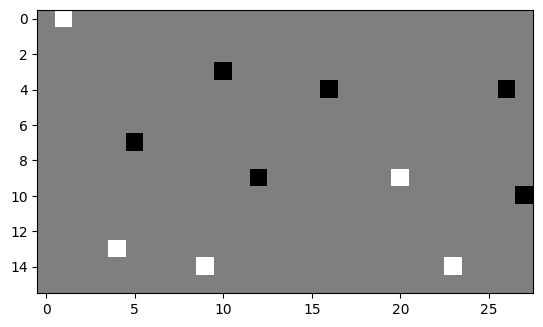

In [7]:
img = plt.imshow(template, cmap=plt.cm.gray, interpolation='none')

Sometimes it is nice to have this stimulus visualized exactly as it was shown on the monitor:

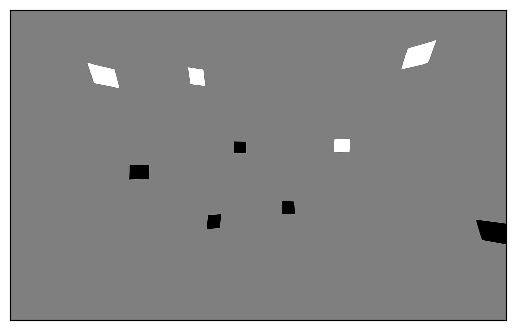

In [8]:
m = si.BrainObservatoryMonitor()
img_screen = m.lsn_image_to_screen(template)
m.show_image(img_screen, warp=True)

During a Brain Observatory experiment, the image on the screen (for example, above) is warped so that spherical coordinates could be displayed on a flat monitor.  When an stimulus frame is displayed without this warping, it is useful to overlay a mask of the eventual maximal extent of the stimulus that will be shown on the monitor.

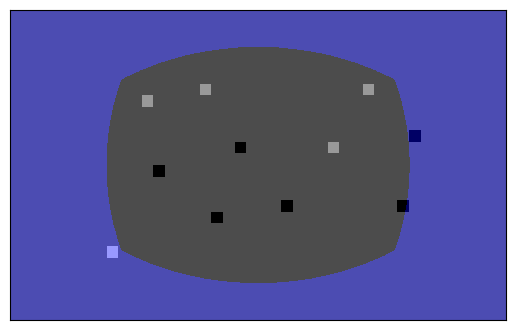

In [9]:
m = si.BrainObservatoryMonitor()
img_screen = m.lsn_image_to_screen(template)
m.show_image(img_screen, warp=False, mask=True)

Using the ```map_stimulus_coordinate_to_monitor_coordinate``` function, we can assosicate a position on the monitor (eitherpre- or post-warp) between multiple types of stimuli, despite the fact the templates for these stimuli might have different sizes and aspect ratios.

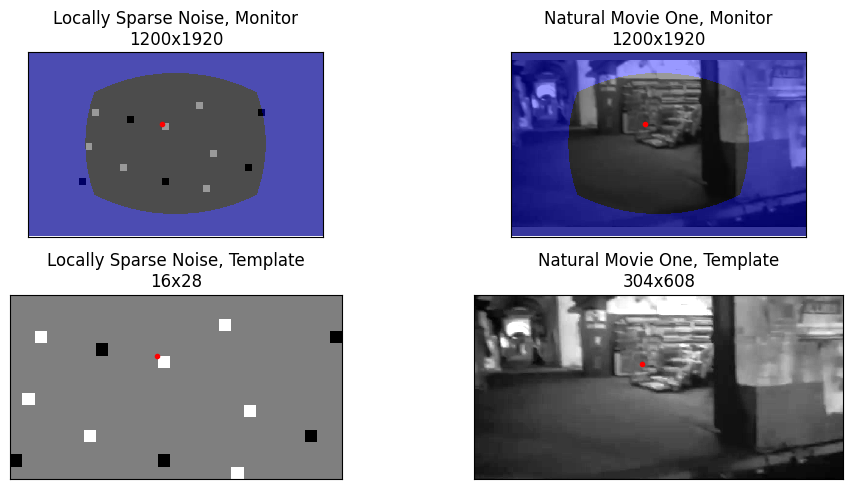

In [10]:
y0, x0 = (5,12)
y1, x1 = m.map_stimulus((y0, x0), si.LOCALLY_SPARSE_NOISE, si.NATURAL_MOVIE_ONE)
ym, xm = si.map_stimulus_coordinate_to_monitor_coordinate((y0, x0), 
                                                          (m.n_pixels_r, m.n_pixels_c), 
                                                          si.LOCALLY_SPARSE_NOISE)

img_lsn =  nwb_dataset.get_stimulus_template('locally_sparse_noise')[0,:,:]
img_movie =  nwb_dataset.get_stimulus_template('natural_movie_one')[0,:,:]


fig, ax = plt.subplots(2,2, figsize=(10,5))
natural_movie_image = m.natural_movie_image_to_screen(img_movie, origin='upper')
m.show_image(natural_movie_image, 
             ax=ax[0,1], 
             show=False, 
             origin='upper', 
             mask=True)
ax[0,1].plot([xm], [ym], 'r.')
ax[0,1].set_title('Natural Movie One, Monitor\n1200x1920')
lsn_image = m.lsn_image_to_screen(img_lsn, origin='upper')
m.show_image(lsn_image, 
             ax=ax[0,0], 
             show=False, 
             origin='upper', 
             mask=True)
ax[0,0].plot([xm], [ym], 'r.')
ax[0,0].set_title('Locally Sparse Noise, Monitor\n1200x1920')

ax[1,0].imshow(np.flipud(img_lsn), interpolation='none', cmap=plt.cm.gray, 
               extent=[0,img_lsn.shape[1],img_lsn.shape[0],0])
ax[1,0].plot([x0], [y0], 'r.')
ax[1,0].axes.get_xaxis().set_visible(False)
ax[1,0].axes.get_yaxis().set_visible(False)
ax[1,0].set_xlim((0, img_lsn.shape[1]-1))
ax[1,0].set_ylim((img_lsn.shape[0]-1, 0))
ax[1,0].set_title('Locally Sparse Noise, Template\n16x28')

ax[1,1].imshow(img_movie, interpolation='none', cmap=plt.cm.gray,
               extent=[0,img_movie.shape[1],img_movie.shape[0],0])
ax[1,1].plot([x1], [y1], 'r.')
ax[1,1].axes.get_xaxis().set_visible(False)
ax[1,1].axes.get_yaxis().set_visible(False)
ax[1,1].set_xlim((0, img_movie.shape[1]-1))
ax[1,1].set_ylim((img_movie.shape[0]-1, 0))
ax[1,1].set_title('Natural Movie One, Template\n304x608')


fig.tight_layout()

For example, in the top row of the figure above, the same position on the monitor (pre-warp) is marked in two different stimuli (left: locally sparse noise, right: natural movie).  Below, the same point is reproduced on the template image for reach stimuli. You can see that in both images, the relative location of the marked point (red) is the same in both the pre-warp monitor image and the template image. This example demonstrates how to co-register locations between stimulus sets.  

An optional `translation` argument will reposition the stimulus frame relative to a gray background canvas; translation in supplied in units of monitor pixels:

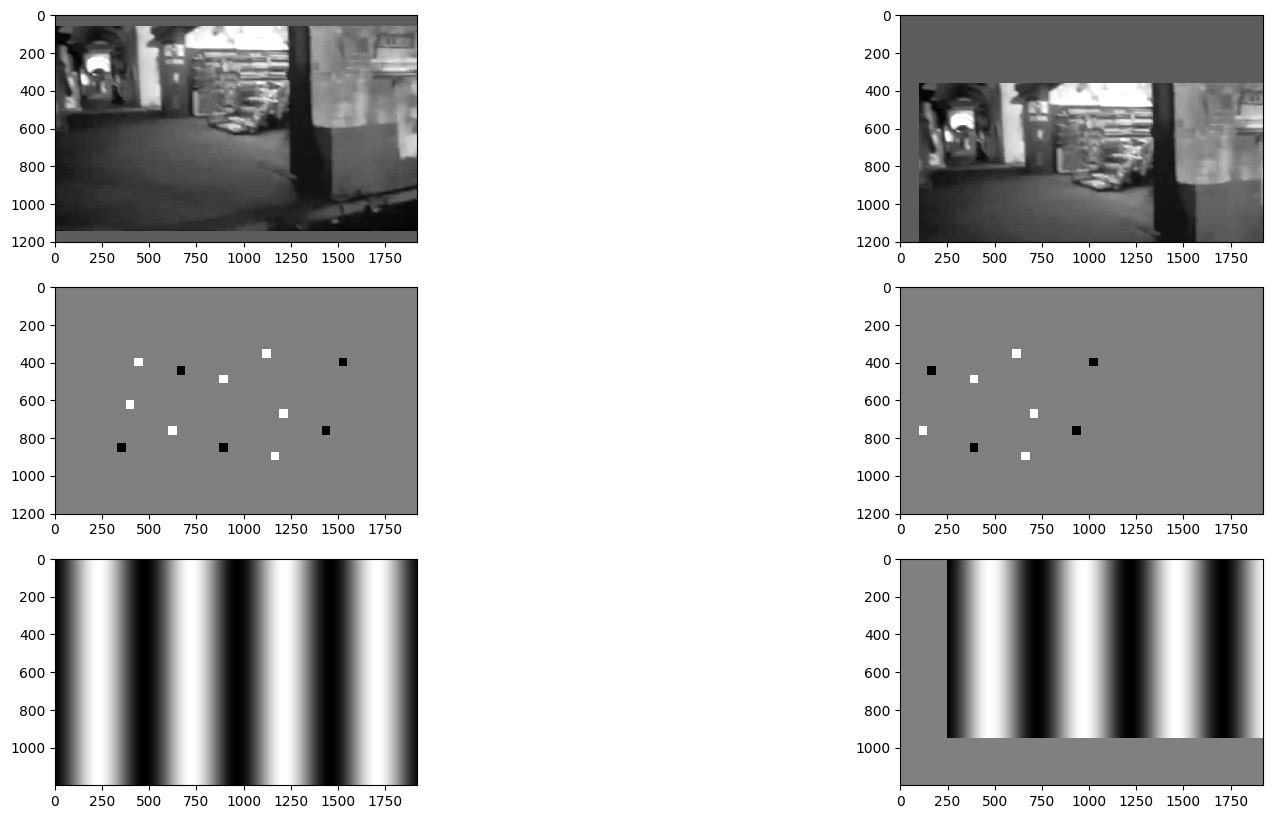

In [11]:
origin = 'upper'
img_movie =  nwb_dataset.get_stimulus_template(si.NATURAL_MOVIE_ONE)[0,:,:]
natural_movie_image = m.natural_movie_image_to_screen(img_movie, origin=origin)
natural_movie_image_translated = m.natural_movie_image_to_screen(img_movie, origin=origin, translation=(100,-300))

img_lsn =  nwb_dataset.get_stimulus_template(si.LOCALLY_SPARSE_NOISE)[0,:,:]
lsn_image = m.lsn_image_to_screen(img_lsn, origin=origin)
img_lsn_translated = m.lsn_image_to_screen(img_lsn, origin=origin, translation=(-500,0))

img_grating = m.grating_to_screen(.5,.02,0)
img_grating_translated = m.grating_to_screen(.5,.02,0, translation=(250,250))


fig, ax = plt.subplots(3,2, figsize=(20,10))
_ = ax[0,0].imshow(natural_movie_image, interpolation='none', cmap=plt.cm.gray,
                   extent=[0,natural_movie_image.shape[1],natural_movie_image.shape[0],0])
_ = ax[0,1].imshow(natural_movie_image_translated, interpolation='none', cmap=plt.cm.gray,
                   extent=[0,natural_movie_image_translated.shape[1],natural_movie_image_translated.shape[0],0])
_ = ax[1,0].imshow(lsn_image, interpolation='none', cmap=plt.cm.gray,
                   extent=[0,lsn_image.shape[1],lsn_image.shape[0],0])
_ = ax[1,1].imshow(img_lsn_translated, interpolation='none', cmap=plt.cm.gray,
                   extent=[0,img_lsn_translated.shape[1],img_lsn_translated.shape[0],0])
_ = ax[2,0].imshow(img_grating, interpolation='none', cmap=plt.cm.gray,)
_ = ax[2,1].imshow(img_grating_translated, interpolation='none', cmap=plt.cm.gray)